LIF neuron : $U[t+1]=\beta U[t] + WX[t+1]-R[t]$  
input synaptic : $I_{in}[t] = WX[t]$  
input spike : $X[t]$  
output spike : $S[t]$  
$\beta$ : both hyperparameter & learnable parameter

training networks : loss with weights  
$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial S[t]} \frac{\partial S[t]}{\partial U[t]} \frac{\partial U[t]}{\partial I[t]} \frac{\partial I[t]}{\partial W}$  
$\frac{\partial S[t]}{\partial U[t]}=\{0, \infty\}$ => dead neuron probelm => surrogate function  
forward propagation은 같게 backpropagation=$\frac{\partial \tilde{S}}{\partial U} = \frac{1}{\pi} \frac{1}{(1+[U\pi]^2)}$

In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
class LeakySurrogate(nn.Module):
    def __init__(self, beta, threshold=1.0):
        super(LeakySurrogate, self).__init__()

        self.beta = beta
        self.threshold = threshold
        self.spike_gradient = self.ATan.apply

    def forward(self, input_, mem):
        spk = self.spike_gradient(mem - self.threshold) # call heaviside
        reset = (self.beta*spk*self.threshold).detach()
        mem = self.beta*mem + input_ - reset
        return spk, mem
    
    @staticmethod  # 데코레이터 -> self 안씀
    class ATan(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem): # heaviside funtion
            spk = (mem > 0).float() # mem-threshold>0 -> return 1
            ctx.save_for_backward(mem) # forward 계산한 mem 저장
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            (mem, )=ctx.saved_tensors
            grad = 1/ (1+(np.pi*mem).pow_(2))
            return grad

In [3]:
lif1 = LeakySurrogate(beta=0.9)

In [4]:
lif1 = snn.Leaky(beta=0.9) # 구현되어있다

사실 backpropagation은 모든 시간을 고려해야한다. 전의 loss의 sum과 지금의 loss를 더해야한다.

### setting decoding
rate coding : 정답인 label이 평균 firing이 가장 높게  
=> 정답의 U를 높게, 오답의 U는 낮게(weight 조절)  
** 결과는 spike로 판단하지만 계산과정에서 U(막전위)를 쓰겠다(연속값이라 계산 easy)

In [5]:
import torch

batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
    ])



In [7]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

--2026-02-10 05:51:20--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2026-02-10 05:51:21--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.3’

MNIST.tar.gz.3          [ <=>                ]  33.20M   131KB/s    in 6m 39s  

2026-02-10 05:58:02 (85.1 KB/s) - ‘MNIST.tar.gz.3’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [8]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)  

In [9]:
# define network
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

num_steps = 25
beta = 0.95

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        mem2_rec = []
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

In [11]:
# training
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1)) # output : spike 기록, _ : mem
    # _ : 알 필요 없는 정보를 이렇게 전달한다. 메모리 절약
    _, idx = output.sum(dim=0).max(1) # max(1) 한 행에서 가장 큰 클래스(값 아니고 인덱스) 찾아 저장
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f'Train set accuracy for a single minibatch: {acc*100:.2f}')

    else:
        print(f'Test set accuracy for a single minibatch: {acc*100:.2f}')

def train_printer(
        data, targets, epoch, counter, iter_counter, loss_hist, test_loss_hist, test_data, test_targets):
    print(f'Epoch {epoch}, Iteration {iter_counter}')
    print(f'Train Set Loss: {loss_hist[counter]:.2f}')
    print(f'Test Set Loss: {test_loss_hist[counter]:.2f}')
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print('\n')

In [12]:
loss = nn.CrossEntropyLoss()

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [14]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [ ]:
spk_rec, mem_rec = net(data.view(batch_size, -1)) # flatten
print(mem_rec.size()) # (time_steps, samples, num_outputs)

torch.Size([25, 128, 10])


In [16]:
loss_val = torch.zeros((1), dtype=dtype, device=device)

for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)

print(f'Training loss: {loss_val.item():.3f}')

Training loss: 61.444


In [17]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 8.59


In [ ]:
optimizer.zero_grad() # gradient 초기화
loss_val.backward() # gradient 계산
optimizer.step() # weight 업데이트

In [ ]:
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)
# loss 감소. accuracy 증가

Training loss: 47.946
Train set accuracy for a single minibatch: 37.50


In [20]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 52.99
Test Set Loss: 50.10
Train set accuracy for a single minibatch: 48.44
Test set accuracy for a single minibatch: 35.94


Epoch 0, Iteration 50
Train Set Loss: 11.86
Test Set Loss: 10.61
Train set accuracy for a single minibatch: 88.28
Test set accuracy for a single minibatch: 89.84


Epoch 0, Iteration 100
Train Set Loss: 13.82
Test Set Loss: 9.00
Train set accuracy for a single minibatch: 87.50
Test set accuracy for a single minibatch: 85.94


Epoch 0, Iteration 150
Train Set Loss: 9.29
Test Set Loss: 7.50
Train set accuracy for a single minibatch: 90.62
Test set accuracy for a single minibatch: 89.06


Epoch 0, Iteration 200
Train Set Loss: 8.84
Test Set Loss: 6.49
Train set accuracy for a single minibatch: 91.41
Test set accuracy for a single minibatch: 92.19


Epoch 0, Iteration 250
Train Set Loss: 7.70
Test Set Loss: 5.46
Train set accuracy for a single minibatch: 90.62
Test set accuracy for a single minibatch: 92.97


Epoch 0, Iteration 3

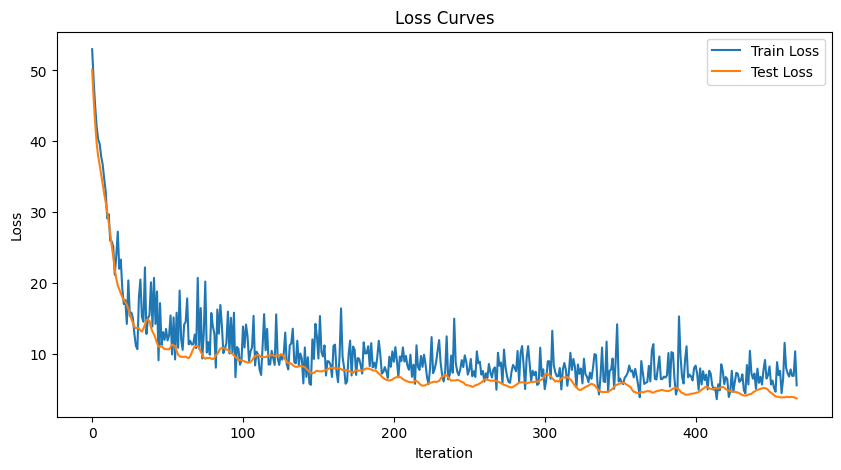

In [21]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [22]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9413/10000
Test Set Accuracy: 94.13%
